# Model stats

In [17]:
import os
import time
import scipy
import random
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
import numpy as np

from tensorflow.keras.preprocessing.image import ImageDataGenerator
tfk = tf.keras
tfkl = tf.keras.layers

In [18]:
# TODO SET ONCOLAB = TRUE IF WORKING ON COLAB
onColab = True
if onColab:
  from google.colab import drive
  drive.mount('/gdrive')
  %cd /gdrive/MyDrive/University/ANN/CHALLENGE1/with_img_divided
  !ls

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/.shortcut-targets-by-id/14nAfiUIlOkzENFAyByV5FH1KxQM8uSlm/CHALLENGE1/with_img_divided
 ckpt_densenet_best_no_ft_new_DS_weightOnClasses
 ckpt_EfficientNetB0_best_no_ft_frozen_new_DS_weightOnClasses
 ckpt_EfficientNetB1_best_no_ft_frozen_new_DS_weightOnClasses
 ckpt_mynet_trial_1
 ckpt_mynet_trial_2
'Copia di stats.ipynb'
 dataset.zip
 densenet_best_no_ft_new_DS_weightOnClasses
 EfficientNetB0_best_no_ft_frozen_new_DS_weightOnClasses
 EfficientNetB1_best_no_ft_frozen_new_DS_weightOnClasses
 EfficientNetB7_best_no_ft_frozen_new_DS_weightOnClasses
 model.png
 moreDivision
 my_net.ipynb
 mynet_trial_2.ipynb
 on_new_ds_new_pipeline.ipynb
 on_new_ds_new_pipeline_no_hidden.ipynb
 test
 training


In [19]:
# TODO CHANGE DATASET_PATH AND PATH_TO_MODEL AND PREPROCESSING FUNCTION
path_to_model = './ckpt_mynet_trial_1'
dataset_path = './training'

batch_size = 128
validation_split = 0.3

def tl_preprocess(x):
  #return tf.keras.applications.efficientnet.preprocess_input(x)
  return x

In [20]:
#@title init seed everywhere
seed =20

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [21]:
img_h, img_w = (256, 256)

def load_data(dontUseFun=True, fun=None, isTest = False):
  """
  load data (train, val, test)
  dontUseFun: if it's true then the data is not preprocessed. If it's false, the data is preprocessed with fun (which must not be none)
  """
  image_generator = ImageDataGenerator(preprocessing_function = fun, validation_split=validation_split, 
                                          rotation_range=30,
                                          height_shift_range=50,
                                          width_shift_range=50,
                                          zoom_range=0.3,
                                          horizontal_flip=True,
                                          vertical_flip=True, 
                                          fill_mode='reflect')  
  if dontUseFun:
    image_generator = ImageDataGenerator(validation_split=validation_split, 
                                          rotation_range=30,
                                          height_shift_range=50,
                                          width_shift_range=50,
                                          zoom_range=0.3,
                                          horizontal_flip=True,
                                          vertical_flip=True, 
                                          fill_mode='reflect')  


  # Obtain a data generator with the 'ImageDataGenerator.flow_from_directory' method
  train_gen = image_generator.flow_from_directory(directory=dataset_path,
                                                target_size=(img_h, img_w),
                                                color_mode='rgb',
                                                classes=None, # can be set to None
                                                class_mode='categorical',
                                                subset='training',
                                                batch_size=batch_size,
                                                shuffle=True,
                                                seed=seed)

  valid_gen = image_generator.flow_from_directory(directory=dataset_path,
                                                target_size=(img_h, img_w),
                                                color_mode='rgb',
                                                classes=None, # can be set to None
                                                class_mode='categorical',
                                                subset='validation',
                                                batch_size=batch_size,
                                                shuffle=False,
                                                seed=seed)
  test_gen = None
  if isTest:
    test_image_gen = ImageDataGenerator(preprocessing_function = fun)
    if dontUseFun:
      test_image_gen = ImageDataGenerator(rotation_range=30)
    
    test_gen = test_image_gen.flow_from_directory(directory=test_path,
                                                target_size=(img_h, img_w),
                                                color_mode='rgb',
                                                classes=None, # can be set to None
                                                class_mode='categorical',
                                                batch_size=batch_size,
                                                shuffle=True, # sometimes, instead of train, we use the test for training
                                                seed=seed)
  return train_gen, valid_gen, test_gen

In [22]:
def preprocess(x):
  # x = clean_image(x)
  if tl_preprocess:
    return tl_preprocess(np.uint8(x))
  return x

In [23]:
train_gen, valid_gen, test_gen = load_data(False, preprocess)

Found 12304 images belonging to 23 classes.
Found 5256 images belonging to 23 classes.


In [24]:
model = tf.keras.models.load_model(path_to_model)

## Visualize performance

In [25]:
labels = list(train_gen.class_indices.keys())

In [26]:
from sklearn.metrics import confusion_matrix
Y_pred = model.predict(valid_gen)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
cm = confusion_matrix(valid_gen.classes, y_pred)

Confusion Matrix


In [27]:
print(cm)

[[ 125    9    3    0    5    0    0    1    0    1    2    1    1    0
     0    0    0    2    0    1    0    1    1]
 [   0  139    1    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    1]
 [   0    1  134    0    3    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    1    0    0    0]
 [   0    1    0   73    0    0    0    0    0    1    0    0    1    0
     0    0    0    2    0    0    0    0    0]
 [   0    0    0    0   95    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [   0    0    0    0    0  107    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0]
 [   0    1    1    0    1    2  244    0    0    0    0    0    0    0
     0    0    0    0    0    0    1    0    1]
 [   0    0    0    0    0    0    0   88    1    0    0    0    0    0
     0    0    0    0    0    2    0    0    0]
 [   0    1    0    0    0    0    0    

In [28]:
!pip install seaborn

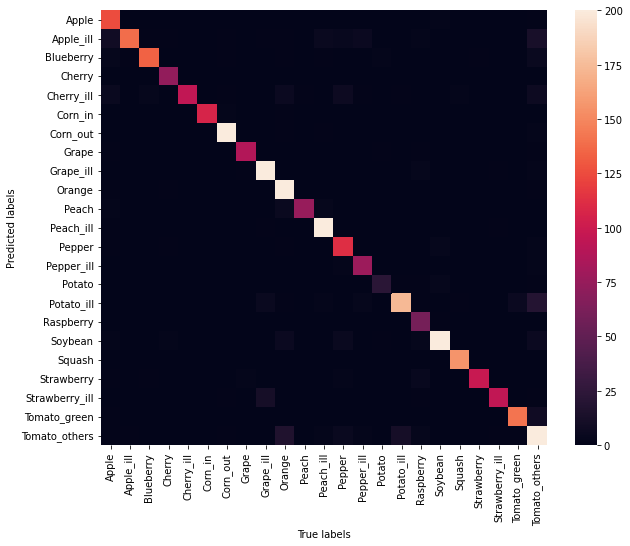

In [29]:
# Let's replot the heatmap but this time we put vmax = 200, so that tomatoes don't cloud the colors of the heatmap and we can visualize the distribution a bit better
import seaborn as sns
plt.figure(figsize=(10,8))
sns.heatmap(cm.T, xticklabels=labels, yticklabels=labels, vmax=200)
plt.xlabel('True labels')
plt.ylabel('Predicted labels')
plt.show()

In [30]:
# # Compute the classification metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
target = valid_gen.classes
predictions = Y_pred
accuracy = accuracy_score(target, np.argmax(predictions, axis=1))
precision = precision_score(target, np.argmax(predictions, axis=1), average='macro')
recall = recall_score(target, np.argmax(predictions, axis=1), average='macro')
f1 = f1_score(target, np.argmax(predictions, axis=1), average='macro')
print('Accuracy:',accuracy.round(4))
print('Precision:',precision.round(4))
print('Recall:',recall.round(4))
print('F1:',f1.round(4))

Accuracy: 0.9448
Precision: 0.9235
Recall: 0.9341
F1: 0.9253


## Visualize model

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 256, 256, 3)  12          ['Input[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 256, 256, 64  1792        ['Conv1[0][0]']                  
                                )                                                                 
                                                                                              

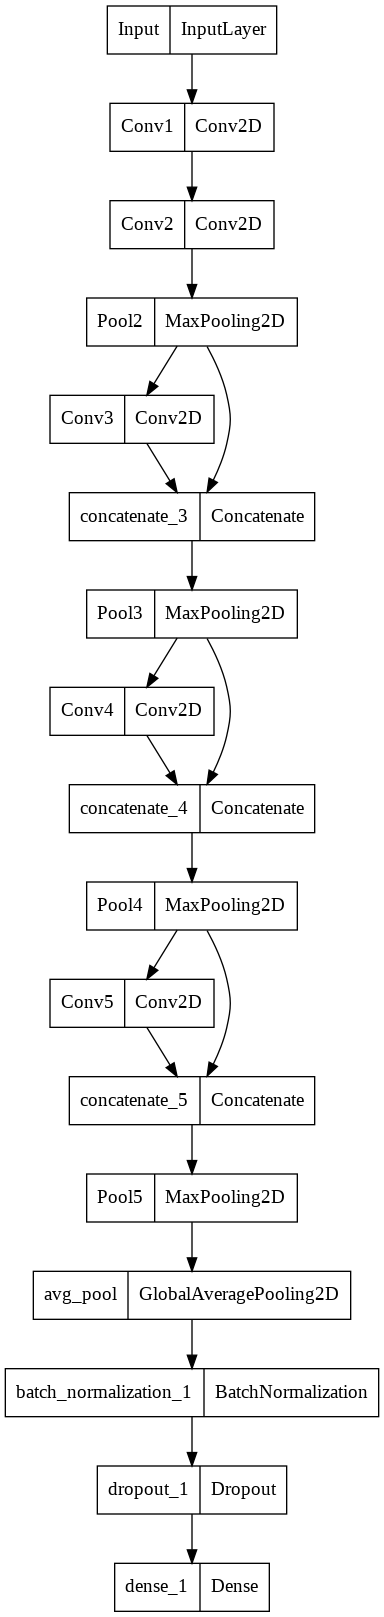

In [31]:
model.summary()
tfk.utils.plot_model(model)

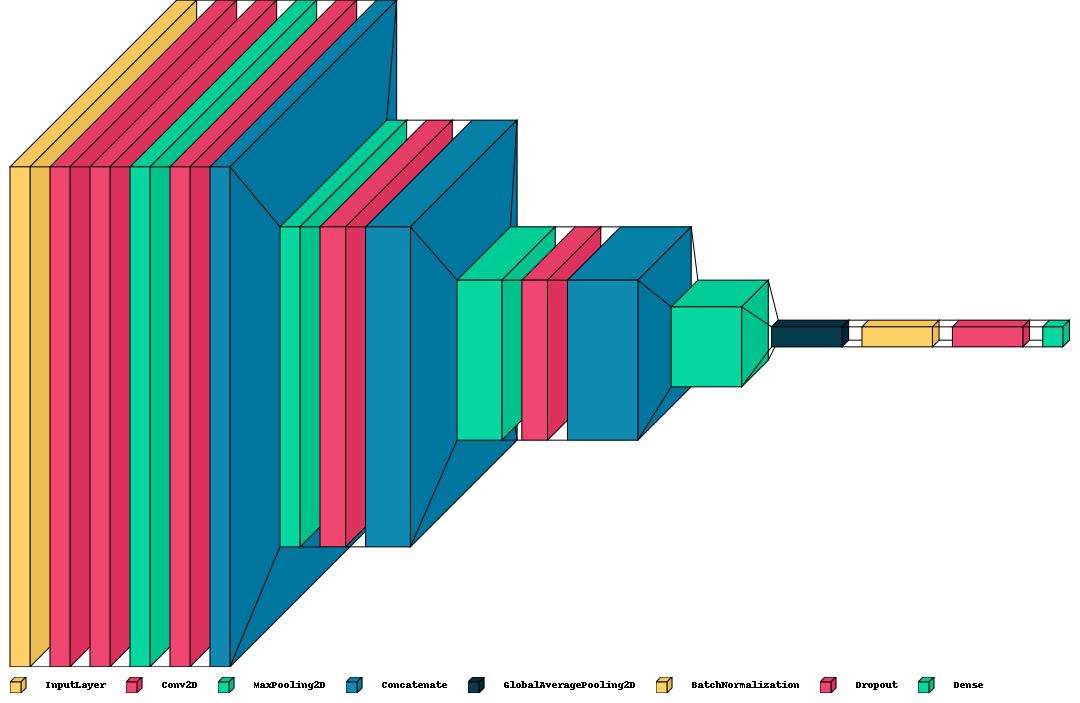

In [32]:
!pip install visualkeras
import visualkeras
visualkeras.layered_view(model, legend=True, spacing=20, scale_xy=5, max_xy=500)